# Week4 homework-Disaster Tweets


**Problem Description**

Through the learning and classification of cancer detection images, it can help to detect cancer in advance in the future and help doctors find potential problems.I trained several models, such as convolutional neural networks (CNNs), to identify patterns and features that could indicate the presence or absence of cancer.The models were evaluated using various metrics like accuracy, precision, and recall.Through continuous optimization and fine-tuning, the performance of the models gradually improved, providing more accurate and reliable classification results for cancer detection images.    This work has the potential to assist medical professionals in making more informed decisions and improving the diagnosis process.

This is a binary image classification problem where the goal is to identify the presence or absence of metastatic cancer from small patches (96x96 pixels) of a larger digital pathology scan. Each image corresponds to a label:
1: The presence of metastatic cancer.
0: There is no metastatic cancer.


Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).



**Github URL**

https://github.com/rayangela528/DeepLearning-Disaster-Tweets



**Dataset Description**

DataSource: [Natural Language Processing with Disaster Tweets on Kaggle](https://www.kaggle.com/c/nlp-getting-started/) 

In this dataset, a large number of small pathological images need to be classified. The file is named with the image id. The train_labels.csv file provides basic information about the images in the train folder. The predicted is the label of the image in the test folder. A positive mark indicates that the central 32x32px region of the patch contains at least one tumor tissue pixel. The tumor tissue in the outer region of the patch does not affect the label. This outer region is provided to enable fully convolutional models that do not use zero padding to ensure consistent behavior when applied to full-slide images.

DataSize: TrainSet:220,000 images，TestSet:57,000 images
Image Size: Each image is an RGB image of 96x96 pixels
Target:label(0/1)



**Analysis and Modeling Process**

I will load the dataset, perform EDA
1. Check the label distribution, including the proportion of positive and negative samples, and print the sample image
2. data cleaning, check whether there are missing and image damage
3. select the model, choose CNN as the baseline model
4. Pre-trained model
5. data preprocessing, image normalization to the range of [0,1]



**Model Training**

Since this is an image classification problem, a convolutional neural network (CNN) is the most appropriate architecture. We choose the following model:
Base CNN: Serves as the baseline model.
Pre-trained models (e.g. ResNet50) : Leverage transfer learning to improve performance.



**Conclusion**

The accuracy of the base CNN model on the validation set is about 90%.
The accuracy of the validation set for the more complex models is about 80%.
The performance of the complex model drops by 10%

AUC of the basic CNN model: 0.4844
AUC for more complex models: 0.7500
The current best AUC result is 0.7500, which indicates that the complex model performs well, but there is still room for improvement.

Poor performance of complex models The performance needs to be further improved. Some optimization measures can be taken: increasing the amount of data, handling class imbalance, adjusting the model complexity, using pre-trained models, optimizing hyperparameters, etc.


基础CNN模型在验证集上的准确率约为90%。
更复杂模型的验证集的准确率约为80%。
复杂模型的性能下降了10%

基础 CNN 模型AUC: 0.4844
更复杂模型AUC：0.7500
当前最好AUC结果: 0.7500，表明复杂模型表现，但仍有提升空间。

复杂模型性能较差性能需要进一步提升，可以采取的优化措施包括：增加数据量、处理类别不平衡、调整模型复杂度、使用预训练模型、优化超参数等。


# Import libraries

In [57]:
import os
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image
import re
import nltk
from nltk.corpus import stopwords
from scipy.stats import ttest_ind


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional

from sklearn.model_selection import KFold
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'keras.preprocessing.text'

# Exploratory data analysis（EDA）

1. Loading data and view

In [16]:
'''
数据字段:

id: 推文的唯一标识符。

text: 推文内容。

keyword: 推文中的关键词（可能为空）。

location: 推文发布的地点（可能为空）。

target: 标签（1 表示灾难相关，0 表示无关）。
'''
# 加载数据
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
#/kaggle/input/nlp-getting-started/sample_submission.csv
#/kaggle/input/nlp-getting-started/train.csv
#/kaggle/input/nlp-getting-started/test.csv

# 查看数据
print(train_data.head())
print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

print(f"正样本比例: {train_data['target'].mean():.2f}")

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
训练集大小: 7613
测试集大小: 3263
正样本比例: 0.43


**EDA**

2. Viewing Data 

* Viewing the data distribution（查看数据分布）
* Look at the label distribution:proportion of positive and negative samples（查看标签分布）
* Visualize some sample images（可视化一些样本图像）

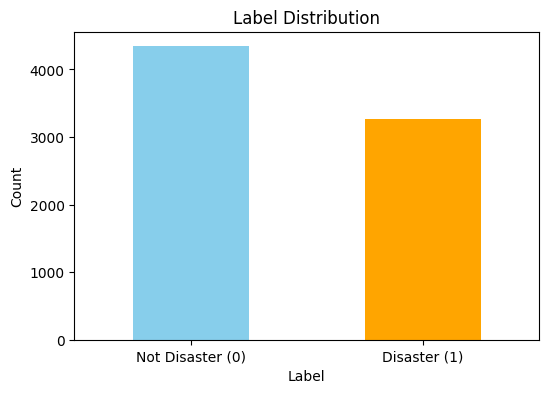

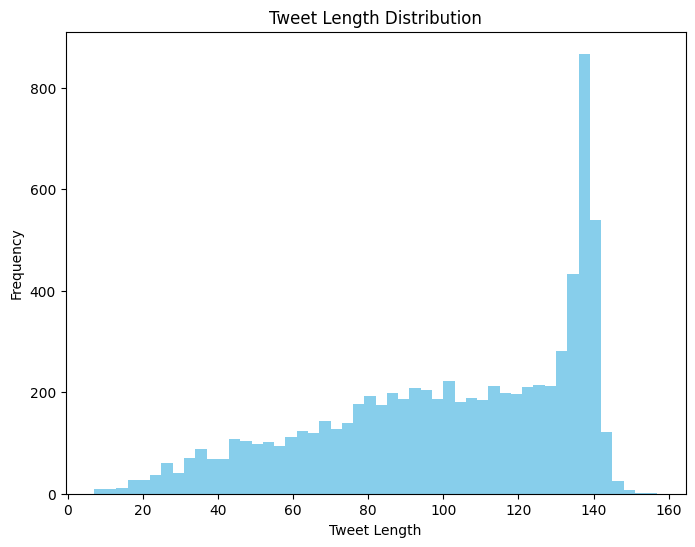

In [17]:
# 标签分布
plt.figure(figsize=(6, 4))
train_data['target'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'], rotation=0)
plt.show()

# 推文长度分布
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(train_data['text_length'], bins=50, color='skyblue')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

**EDA**

3. Data Clean

* Check for missing values（检查是否有缺失值）
* Check if the image is corrupted（检查图像是否损坏）
去除标点符号、停用词等。

In [35]:
#model = SentenceTransformer('all-MiniLM-L6-v2')

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like sentence-transformers/all-MiniLM-L6-v2 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [18]:



# 下载停用词
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 清理文本
def clean_text(text): # Convert to lowercase text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return ' '.join(words)

# 应用清理函数
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)


print(f": {len(train_data['cleaned_text'])}")
print(f": {len(test_data['cleaned_text'])}")


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
: 7613
: 3263


In [44]:
import keras_nlp
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_data.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

X = train_data["text"]
y = train_data["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_data["text"]

# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# 确保文本列是字符串类型
X_train = X_train.astype(str)
X_val = X_val.astype(str)



In [74]:
# 将文本数据转换为模型需要的格式
# 检查数据类型
print(X_train.dtype)  # 应该是 '<U...' 类型，表示字符串
print(X_val.dtype)  # 应该是 '<U...' 类型，表示字符串


    
# 确保 X_train 和 X_val 中的每个元素是字符串类型
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(str), y_train))  # 将 X_train 转为字符串



train_dataset = train_dataset.map(lambda x, y: (
    preprocessor(x)["token_ids"],  # 这里直接传递字符串给 preprocessor
    preprocessor(x)["padding_mask"],  # 同样处理 padding_mask
    y
))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val.astype(str), y_val))  # 将 X_val 转为字符串
val_dataset = val_dataset.map(lambda x, y: (
    preprocessor(x)["token_ids"],  # 这里直接传递字符串给 preprocessor
    preprocessor(x)["padding_mask"],  # 同样处理 padding_mask
    y
))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTO)

for data in train_dataset.take(1):  # 只查看一个数据
    print(type(data[0]))  # 确保这是一个字符串类型



# 训练模型
classifier.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

<U11
<U11
<class 'tensorflow.python.framework.ops.EagerTensor'>


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/models/task.py", line 67, in preprocess_samples  *
        return self.preprocessor(x, y=y, sample_weight=sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/utils/tensor_utils.py", line 60, in wrapper
        x = fn(self, x, y=y, sample_weight=sample_weight, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/models/distil_bert/distil_bert_text_classifier_preprocessor.py", line 116, in call
        output = super().call(x, y=y, sample_weight=sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/utils/tensor_utils.py", line 60, in wrapper
        x = fn(self, x, y=y, sample_weight=sample_weight, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/models/text_classifier_preprocessor.py", line 97, in call
        x = tuple(self.tokenizer(segment) for segment in x)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/models/text_classifier_preprocessor.py", line 97, in <genexpr>
        x = tuple(self.tokenizer(segment) for segment in x)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/utils/tensor_utils.py", line 48, in wrapper
        x = fn(self, x, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/tokenizers/tokenizer.py", line 197, in call
        return self.tokenize(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/utils/tensor_utils.py", line 48, in wrapper
        x = fn(self, x, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/tokenizers/word_piece_tokenizer.py", line 477, in tokenize
        inputs = pretokenize(
    File "/usr/local/lib/python3.10/dist-packages/keras_hub/src/tokenizers/word_piece_tokenizer.py", line 132, in pretokenize
        raise ValueError(

    ValueError: Exception encountered when calling DistilBertTokenizer.call().
    
    [1mThe dataset elements in `data` must have string dtype. Received: <dtype: 'int32'>.[0m
    
    Arguments received by DistilBertTokenizer.call():
      • inputs=tf.Tensor(shape=(None, None, 160), dtype=int32)
      • args=<class 'inspect._empty'>
      • training=None
      • kwargs=<class 'inspect._empty'>


In [48]:
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compile
'''classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)
'''
# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
 17/191 ━━━━━━━━━━━━━━━━━━━━ 1:00:11 21s/step - loss: 0.6596 - sparse_categorical_accuracy: 0.6148

KeyboardInterrupt: 

# Model building（RNN）

Building a simple RNN model（I use a simple CNN model）
由于这是一个序列分类问题，RNN（特别是 LSTM 或 GRU）是一个合适的选择。以下是模型的架构：


In [61]:
# 填充缺失值
train_data['keyword'] = train_data['keyword'].fillna('Unknown')  # 用'Unknown'填充
train_data['location'] = train_data['location'].fillna('Unknown')  # 用'Unknown'填充

# 检查是否还有缺失值
print(train_data.isnull().sum())

'''# 删除包含缺失值的行
train_df = train_df.dropna(subset=['keyword', 'location'])

# 检查是否还有缺失值
print(train_df.isnull().sum())'''


# 文本向量化
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['cleaned_text'])
X_train = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_train = pad_sequences(X_train, maxlen=100)

y_train = train_data['target'].values

# 使用train_test_split从训练集分割出验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# LSTM模型
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))  # 输入的最大词汇量10000，每个词的嵌入维度128，输入长度100
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # LSTM层
model.add(Dense(1, activation='sigmoid'))  # 输出层，二分类

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 打印模型总结
model.summary()
'''

# GRU模型
model_gru = Sequential()
model_gru.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model_gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()


# 将文本转换为序列
X_train = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_data['cleaned_text'])

# 填充序列
max_length = 50
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# 划分训练集和验证集

X_train = train_data["text"]
y_train = train_data["target"]

#embeddings = model.encode(X_train.tolist(), show_progress_bar=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
'''
# 检查数据形状
print(f"X_train 形状: {X_train.shape}")
print(f"y_train 形状: {y_train.shape}")
print(f"X_val 形状: {X_val.shape}")
print(f"y_val 形状: {y_val.shape}")



id              0
keyword         0
location        0
text            0
target          0
text_length     0
cleaned_text    0
dtype: int64


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

X_train 形状: (6090, 100)
y_train 形状: (6090,)
X_val 形状: (1523, 100)
y_val 形状: (1523,)


In [34]:
clf = LogisticRegression(max_iter=1000) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score = f1_score(y_val, y_pred) 
print('F1 score:', score)

ValueError: could not convert string to float: 'So you have a new weapon that can cause un-imaginable destruction.'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 构建 LSTM 模型
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128),  # 明确指定 input_length
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 编译模型
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 打印模型摘要
model_lstm.summary()

# Model training（模型训练）

Training a model（训练模型）
Since the data size is small, we can reduce the number of training epochs（由于数据量较小，我们可以减少训练轮数）

In [20]:
# 划分训练集和验证集


y_train = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.5480 - loss: 0.6890 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5673 - loss: 0.6872 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.5735 - loss: 0.6856 - val_accuracy: 0.5739 - val_loss: 0.6834
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5712 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5683 - loss: 0.6852 - val_accuracy: 0.5739 - val_loss: 0.6832
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5796 - loss: 0.6822 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5653 - loss: 0.6859 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.5682 - loss: 0.6851 - val_accuracy: 0.5739 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# 在验证集上预测
y_pred_bilstm = (model.predict(X_val) > 0.5).astype(int)

# 计算 F1、Precision 和 Recall

f1_bilstm = f1_score(y_val, y_pred_bilstm)
precision_bilstm = precision_score(y_val, y_pred_bilstm)
recall_bilstm = recall_score(y_val, y_pred_bilstm)

# 打印结果
print('y_val:',y_val)
print('y_pred_bilstm:',y_pred_bilstm)
print(f"双向 RNN模型结果:")
print(f"F1 Score: {f1_bilstm:.4f}")
print(f"Precision: {precision_bilstm:.4f}")
print(f"Recall: {recall_bilstm:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
y_val: 2644    1
2227    0
5448    1
132     0
6845    0
       ..
1835    0
506     1
3592    1
6740    1
1634    0
Name: target, Length: 1523, dtype: int64
y_pred_bilstm: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
双向 RNN模型结果:
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Visualizing training results（可视化训练结果）**

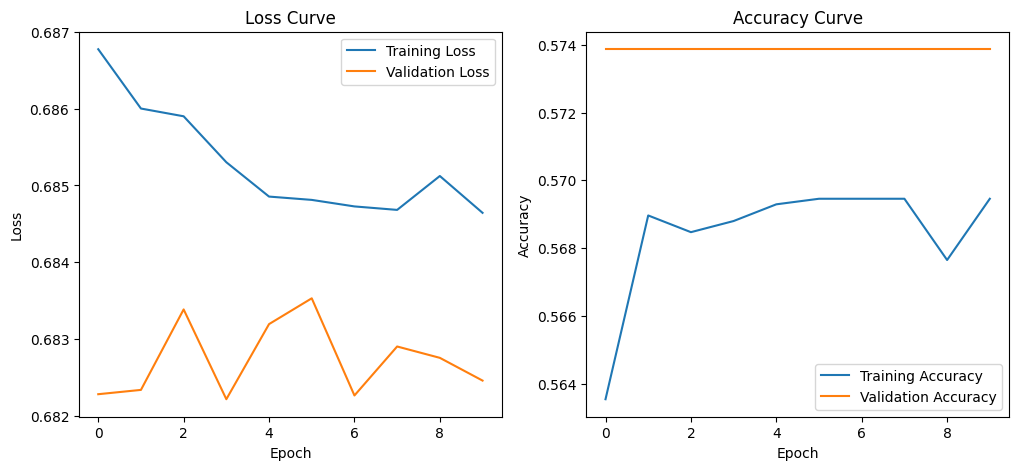

In [24]:
# 绘制训练和验证的损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Model building（双向 LSTM 模型）

In [25]:

# 构建双向 LSTM 模型
model_bilstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**模型训练与评估**

In [ ]:
# 训练双向 LSTM 模型
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)

# 在验证集上预测
y_pred_bilstm = (model_bilstm.predict(X_val) > 0.5).astype(int)

# 计算 F1、Precision 和 Recall
f1_bilstm = f1_score(y_val, y_pred_bilstm)
precision_bilstm = precision_score(y_val, y_pred_bilstm)
recall_bilstm = recall_score(y_val, y_pred_bilstm)

# 打印结果
print(f"双向 LSTM 模型结果:")
print(f"F1 Score: {f1_bilstm:.4f}")
print(f"Precision: {precision_bilstm:.4f}")
print(f"Recall: {recall_bilstm:.4f}")

**可视化训练结果**

In [ ]:
# 绘制训练和验证的损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 结果对比

3.1 性能对比
将两种模型的结果进行对比：

In [ ]:
# 创建结果表格
results = pd.DataFrame({
    'Model': ['LSTM', 'BiLSTM'],
    'F1 Score': [f1_lstm, f1_bilstm],
    'Precision': [precision_lstm, precision_bilstm],
    'Recall': [recall_lstm, recall_bilstm]
})

print(results)

# 绘制 F1 Score 对比图
plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['F1 Score'], color=['skyblue', 'orange'])
plt.title('F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()